# Chapter 3: Trees

In [1]:
# Chapter 3 imports
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import root_mean_squared_error, log_loss
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, ParameterSampler, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay

diamonds = pd.read_parquet("diamonds.parquet")  # Or sns.load_dataset("diamonds")
car = pd.read_parquet("dataCar.parquet")

## Exercises on Random Forests

### Exercise 1

In [2]:
# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)

# Preprocessing
ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

tree_encoder_with_log = ColumnTransformer(
    [
        ("log_carat", FunctionTransformer(np.log), ["carat"]),
        ("ord", OrdinalEncoder(categories=ord_levels), ord_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

# Combine with random forest into clean pipeline
model = make_pipeline(
    tree_encoder_with_log,
    RandomForestRegressor(
        n_estimators=500,
        max_features="sqrt",
        min_samples_leaf=5,
        oob_score=True,
        random_state=17,
        n_jobs=4,
    ),
)

model.fit(df_train, y_train)

# Test performance
rmse_test = root_mean_squared_error(y_test, model.predict(df_test))
print(f"Test RMSE: {rmse_test:.3f}")


Test RMSE: 557.287


**Comment:** The results are essentially identical because log is a monotonic trafo. Differences might come from implementation tricks.

### Exercise 2

In [3]:
# Train/test split (stratified split is simple for discrete responses)
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=5684, stratify=car["clm"]
)

# Model pipeline
num_vars = ["veh_value", "veh_age", "agecat"]
cat_vars = ["gender", "area", "veh_body"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", "passthrough", num_vars),
        ("ordinal", OrdinalEncoder(), cat_vars),
    ],
    verbose_feature_names_out=False,
)

rf = RandomForestClassifier(
    n_estimators=500,
    max_features="sqrt",
    min_samples_leaf=5,
    criterion="entropy",
    max_depth=8,
    n_jobs=4,
)

model = Pipeline(steps=[("preprocessor", preprocessor), ("rf", rf)])

In [4]:
# Grid search for 'max_depth' with CV and five (stratified) folds
search = GridSearchCV(
    model,
    param_grid={"rf__max_depth": range(3, 8)},
    scoring="neg_log_loss",
    cv=5,
)
# Remember: the best model is refitted on training data
search.fit(X=df_train, y=y_train)
print(f"Best max_depth: {search.best_params_}")

Best max_depth: {'rf__max_depth': 4}


In [5]:
# Performance on test data
model = search.best_estimator_
dummy = DummyClassifier().fit(df_train, y_train)

logloss_0, logloss = (
    log_loss(y_test, mod.predict_proba(df_test)) for mod in (dummy, model)
)

print(f"Average log loss: {logloss: .3f}")
print(f"Rel imp in average log loss: {(logloss_0 - logloss) / logloss_0: .3%}")

Average log loss:  0.248
Rel imp in average log loss:  0.204%


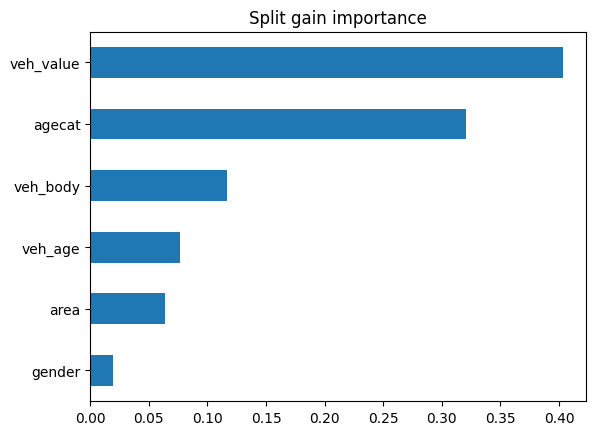

In [6]:
# Variable importance
feature_names = model[0].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot(kind="barh", title="Split gain importance")

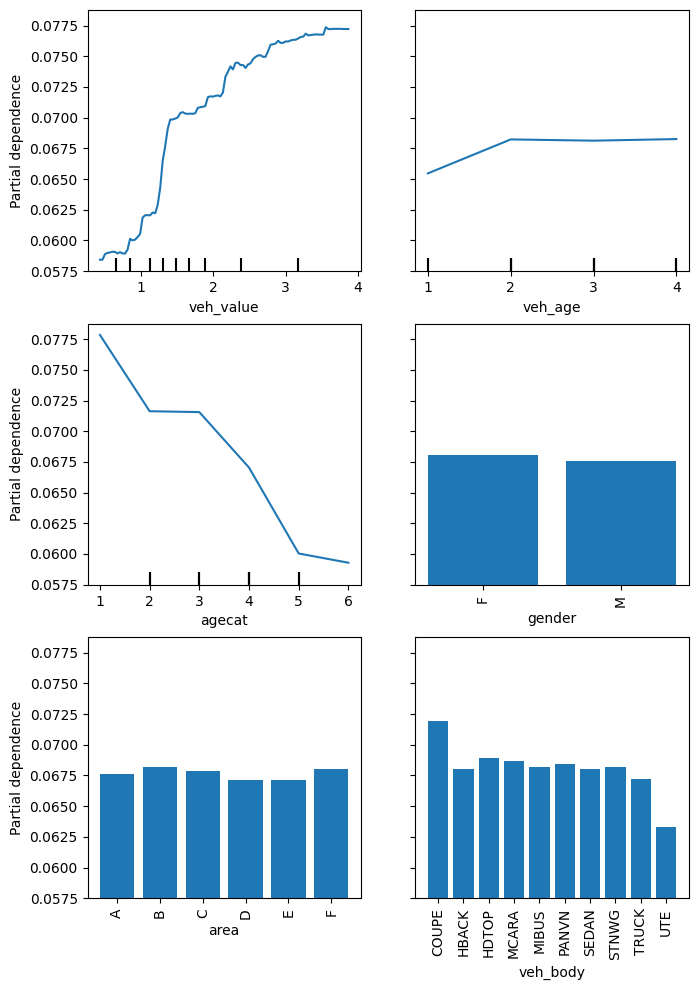

In [7]:
# Partial dependence plots
fig, axes = plt.subplots(figsize=(7, 10))

PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=cat_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()

**Comment:** Test performance with small tree depth seems to be best. When studying relative performance metrics like the relative deviance gain, we can see that performance of the model is very low. TPL claims seem to be mostly determined by bad luck, which makes sense.

## Exercises on Boosting

### Exercise 1

In [8]:
# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    diamonds, diamonds["price"], test_size=0.2, random_state=49
)

# Preprocessing
ord_vars = ["color", "cut", "clarity"]
ord_levels = [diamonds[x].cat.categories.to_list() for x in ord_vars]

tree_encoder = ColumnTransformer(
    [
        ("asis", "passthrough", ["carat"]),
        ("prep", OrdinalEncoder(categories=ord_levels), ord_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

X_train = tree_encoder.fit_transform(df_train)
X_train.head()

,carat,color,cut,clarity
53763,0.76,3.0,2.0,4.0
41292,0.73,3.0,3.0,7.0
40463,0.32,0.0,0.0,1.0
3842,0.90,5.0,2.0,4.0
12445,1.17,6.0,0.0,3.0


In [9]:
# Load grid
grid_file = Path("gridsearch") / "diamonds_xgb.txt"

with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")
search_df.head(1)

,num_boost_round,cv_score,train_score,params
23,355,543.474377,509.026808,"{'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha..."


In [10]:
# Set monotone constraints in right order
bst = search_df.iloc[0]
bst.params["monotone_constraints"] = "(1, 0, 0, 0)"  # Strange API
bst.params

{'subsample': 0.8,
 'reg_lambda': 0,
 'reg_alpha': 0,
 'objective': 'reg:squarederror',
 'min_split_loss': 0.0001,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.02,
 'colsample_bynode': 0.8,
 'monotone_constraints': '(1, 0, 0, 0)'}

In [11]:
# Fit on best params
xgbmodel = XGBRegressor(
    **bst.params,
    n_estimators=bst.num_boost_round,
    random_state=5,
)
_ = model = make_pipeline(tree_encoder, xgbmodel).fit(X=df_train, y=y_train)

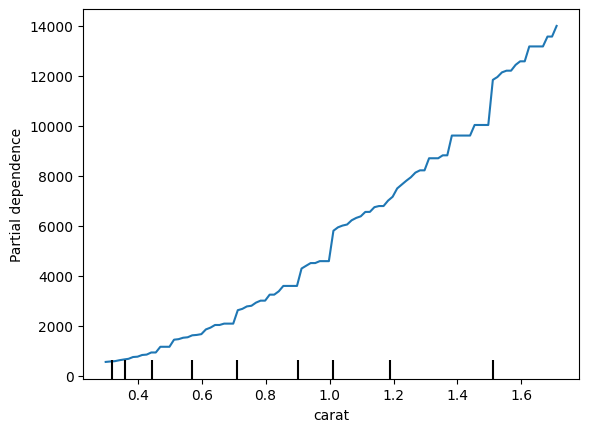

In [12]:
# Partial dependence plot of carat
_ = PartialDependenceDisplay.from_estimator(
    model, features=["carat"], X=df_train.sample(n=1000, random_state=1)
)

**Comment:** The argument is called "monotone_constraints". For each covariate, a value 0 means no constraint, a value -1 means a negative constraints, and a value 1 means positive constraint. Applying the constraint leads to a partial dependence plot that is guaranteed to be monotonically increasing. This is extremely useful in practice. Besides monotonic constraints, also interaction constraints are possible.

### Exercise 2

In [13]:
# We adapt the template from the lecture notes

# Train/test split
df_train, df_test, y_train, y_test = train_test_split(
    car, car["clm"], test_size=0.2, random_state=5684, stratify=car["clm"]
)

# Model pipeline. For simplicity, we treat 'veh_body' as ordinal
num_vars = ["veh_value", "veh_age", "agecat"]
cat_vars = ["gender", "area", "veh_body"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", "passthrough", num_vars),
        ("ordinal", OrdinalEncoder(), cat_vars),
    ],
    verbose_feature_names_out=False,
).set_output(transform="pandas")

dtrain = xgb.DMatrix(preprocessor.fit_transform(df_train), label=y_train)

In [14]:
# Step 1: Find learning rate with reasonable tree count
params = {"objective": "binary:logistic", "learning_rate": 0.01}

# Cross-validation
cvm = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,
    nfold=5,
    stratified=True,
    early_stopping_rounds=20,
    callbacks=[xgb.callback.EvaluationMonitor(period=50)],
)

# A LR of 0.01 provides about 300 trees, which is convenient
print("Best boosting round with default params:\n", cvm.tail(1))

[0]	train-logloss:0.28074	test-logloss:0.28077
[50]	train-logloss:0.26106	test-logloss:0.26235
[100]	train-logloss:0.25178	test-logloss:0.25423
[150]	train-logloss:0.24722	test-logloss:0.25085
[200]	train-logloss:0.24479	test-logloss:0.24953
[250]	train-logloss:0.24332	test-logloss:0.24910
[300]	train-logloss:0.24235	test-logloss:0.24900
[321]	train-logloss:0.24200	test-logloss:0.24900
Best boosting round with default params:
      train-logloss-mean  train-logloss-std  test-logloss-mean  \
301            0.242329           0.000188           0.248999   

     test-logloss-std  
301          0.000425  


In [15]:
# Step 2: Iterate randomized SearchCV for regularization parameters
grid_file = Path("gridsearch") / "claims_xgb.txt"

if False:
    # Use ParameterGrid(...) if grid is small enough to check all combinations
    # Final grid search after some iterations
    grid = ParameterSampler(
        {
            "objective": ["binary:logistic"],
            "learning_rate": [0.01],
            "max_depth": [3, 4, 5, 6],
            "colsample_bynode": [0.8, 1],
            "subsample": [0.8, 1],
            "reg_lambda": [0, 2.5, 5, 7.5],
            "reg_alpha": [0, 4],
            "min_child_weight": [0, 0.1],  # *not* the number of obs with logloss
            "min_split_loss": [0, 0.0001],
        },
        n_iter=32,
        random_state=40,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = xgb.cv(
            params=g,
            dtrain=dtrain,
            num_boost_round=5000,
            nfold=5,
            stratified=True,
            early_stopping_rounds=20,
        )

        # Keep number of rounds, cv score, train score, and parameters
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
2,452,0.247948,0.246709,"{'subsample': 1, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
22,388,0.247956,0.246838,"{'subsample': 1, 'reg_lambda': 0, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 0, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
26,415,0.247981,0.246750,"{'subsample': 0.8, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
30,415,0.247982,0.246750,"{'subsample': 0.8, 'reg_lambda': 2.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0.0001, 'min_child_weight': 0, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 0.8}"
21,413,0.248005,0.246754,"{'subsample': 1, 'reg_lambda': 7.5, 'reg_alpha': 4, 'objective': 'binary:logistic', 'min_split_loss': 0.0001, 'min_child_weight': 0.1, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bynode': 1}"


In [16]:
# Step 3: Fit on best params
best = search_df.iloc[0]
best.num_boost_round, best.params

(452,
 {'subsample': 1,
  'reg_lambda': 2.5,
  'reg_alpha': 4,
  'objective': 'binary:logistic',
  'min_split_loss': 0,
  'min_child_weight': 0.1,
  'max_depth': 3,
  'learning_rate': 0.01,
  'colsample_bynode': 0.8})

In [17]:
xgbmodel = XGBClassifier(
    **best.params,
    n_estimators=best.num_boost_round,
    random_state=5,
    importance_type="gain",
)
_ = model = make_pipeline(preprocessor, xgbmodel).fit(X=df_train, y=y_train)


In [18]:
# Interpret model

# Performance on test data
dummy = DummyClassifier().fit(df_train, y_train)

logloss_0, logloss = (
    log_loss(y_test, mod.predict_proba(df_test)) for mod in (dummy, model)
)

print(f"Average log loss: {logloss: .3f}")
print(f"Rel imp in average log loss: {(logloss_0 - logloss) / logloss_0: .3%}")


Average log loss:  0.248
Rel imp in average log loss:  0.175%


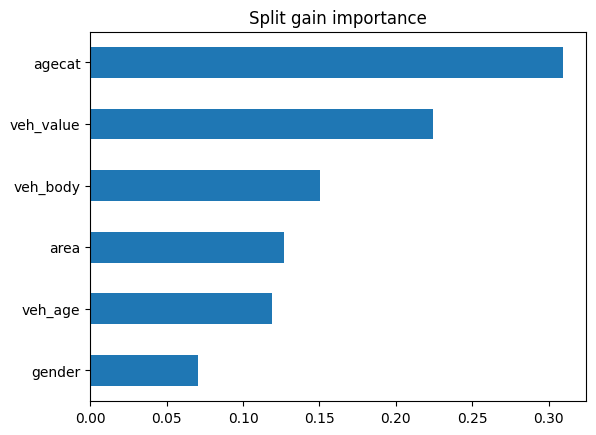

In [19]:
# Split gain importance
feature_names = model[:-1].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot.barh(title="Split gain importance")


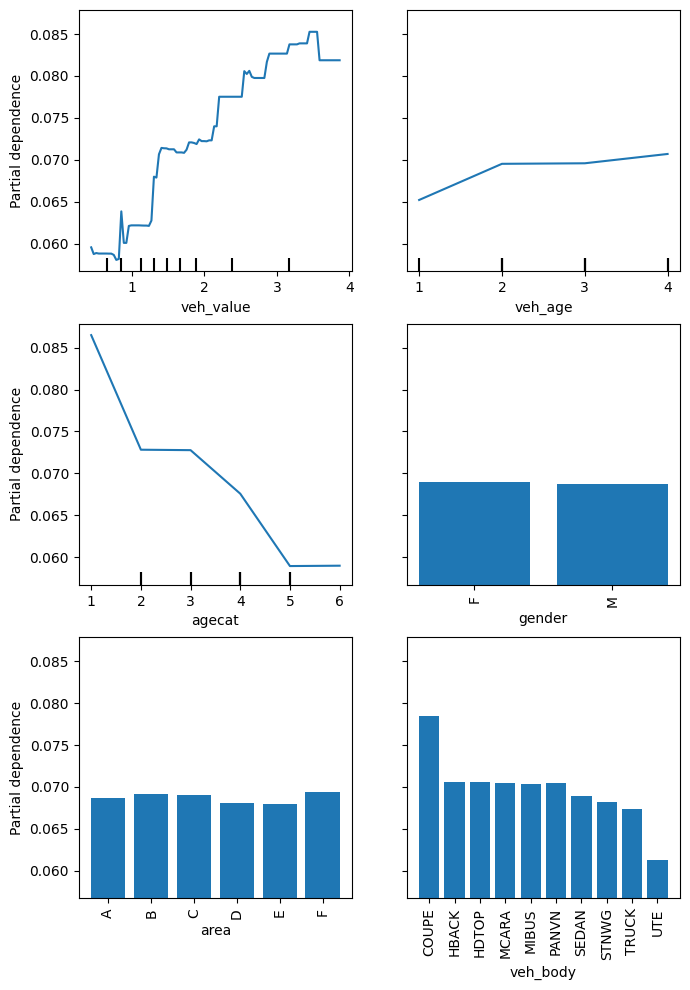

In [20]:
# Partial dependence plots
fig, axes = plt.subplots(figsize=(7, 10))

PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=cat_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()


### Exercise 3 (Optional)

In [21]:
# We reuse and adapt the code from Exercise 2
dtrain = lgb.Dataset(preprocessor.fit_transform(df_train), label=y_train)

In [22]:
# Step 1: Find learning rate with reasonable tree count
params = {
    "objective": "binary",
    "learning_rate": 0.002,
    "verbose": -1,
}

# Cross-validation
cvm = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=5000,
    nfold=5,
    stratified=True,
    eval_train_metric=True,
    callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
)

# A LR of 0.002 provides about 340 trees, which is convenient
cvm = pd.DataFrame(cvm)
print("Best boosting round with default params:\n", len(cvm))
cvm.tail(1)

Best boosting round with default params:
 341


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
340,0.246029,0.000088,0.248273,0.000315


In [23]:
# Step 2: Iterate randomized SearchCV for regularization parameters
grid_file = Path("gridsearch") / "claims_lgb.txt"

if False:
    # Final grid search after some iterations
    grid = ParameterSampler(
        {
            "objective": ["binary"],
            "learning_rate": [0.002],
            "num_leaves": [15, 31, 63],
            "reg_lambda": [0, 4],
            "reg_alpha": [0, 2.5, 5, 7.5],
            "colsample_bynode": [0.8, 1],
            "bagging_fraction": [0.8, 1],
            "min_child_samples": [20, 50, 100],
            "verbose": [-1],
        },
        n_iter=32,
        random_state=94,
    )

    # Iterate over grid and save relevant information on disk
    search = []
    for g in tqdm(grid):
        cvm = lgb.cv(
            params=g,
            train_set=dtrain,
            num_boost_round=5000,
            nfold=5,
            stratified=True,
            seed=82,
            eval_train_metric=True,
            callbacks=[lgb.log_evaluation(period=0), lgb.early_stopping(20, verbose=0)],
        )

        # Keep number of rounds, cv score, train score, and parameters
        cvm = pd.DataFrame(cvm)
        search.append((len(cvm), *cvm.iloc[-1, [2, 0]], g))

        with open(grid_file, "w") as f:
            json.dump(search, f)

# Load grid and check (A) sort order and (B) if grid ranges were set reasonable
with open(grid_file) as f:
    search = json.load(f)

search_df = pd.DataFrame.from_records(
    search, columns=["num_boost_round", "cv_score", "train_score", "params"]
).sort_values("cv_score")

with pd.option_context("display.max_colwidth", None):
    display(search_df.head())

,num_boost_round,cv_score,train_score,params
5,821,0.248130,0.246232,"{'verbose': -1, 'reg_lambda': 0, 'reg_alpha': 2.5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 20, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 1}"
24,819,0.248138,0.246251,"{'verbose': -1, 'reg_lambda': 0, 'reg_alpha': 2.5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 50, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 1}"
2,881,0.248139,0.246472,"{'verbose': -1, 'reg_lambda': 0, 'reg_alpha': 5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 20, 'learning_rate': 0.002, 'colsample_bynode': 1, 'bagging_fraction': 0.8}"
3,824,0.248141,0.246152,"{'verbose': -1, 'reg_lambda': 4, 'reg_alpha': 0, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 50, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 0.8}"
12,687,0.248153,0.246990,"{'verbose': -1, 'reg_lambda': 4, 'reg_alpha': 7.5, 'objective': 'binary', 'num_leaves': 15, 'min_child_samples': 100, 'learning_rate': 0.002, 'colsample_bynode': 0.8, 'bagging_fraction': 0.8}"


In [24]:
# Best parameters
best = search_df.iloc[0]
best.num_boost_round, best.params

(821,
 {'verbose': -1,
  'reg_lambda': 0,
  'reg_alpha': 2.5,
  'objective': 'binary',
  'num_leaves': 15,
  'min_child_samples': 20,
  'learning_rate': 0.002,
  'colsample_bynode': 0.8,
  'bagging_fraction': 1})

In [25]:
# Step 3: Fit on best params
model = make_pipeline(
    preprocessor,
    LGBMClassifier(**best.params, n_estimators=best.num_boost_round, random_state=59),
)
_ = model.fit(X=df_train, y=y_train)

In [26]:
# Interpret model

# Performance on test data
dummy = DummyClassifier().fit(df_train, y_train)

logloss_0, logloss = (
    log_loss(y_test, mod.predict_proba(df_test)) for mod in (dummy, model)
)

print(f"Average log loss: {logloss: .3f}")
print(f"Rel imp in average log loss: {(logloss_0 - logloss) / logloss_0: .3%}")

Average log loss:  0.248
Rel imp in average log loss:  0.232%


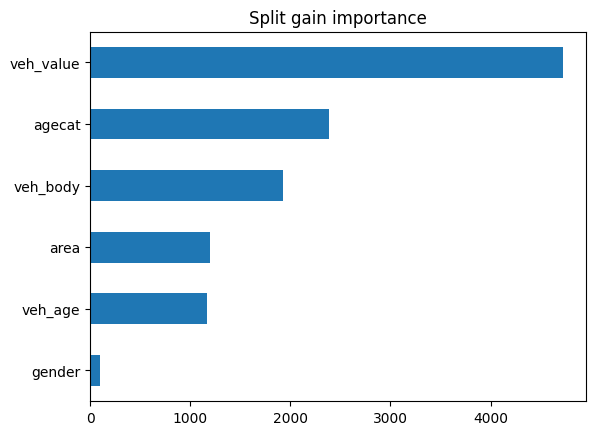

In [27]:
# Split gain importance
feature_names = model[:-1].get_feature_names_out()
imps = pd.Series(model[-1].feature_importances_, index=feature_names)
_ = imps.sort_values().plot.barh(title="Split gain importance")

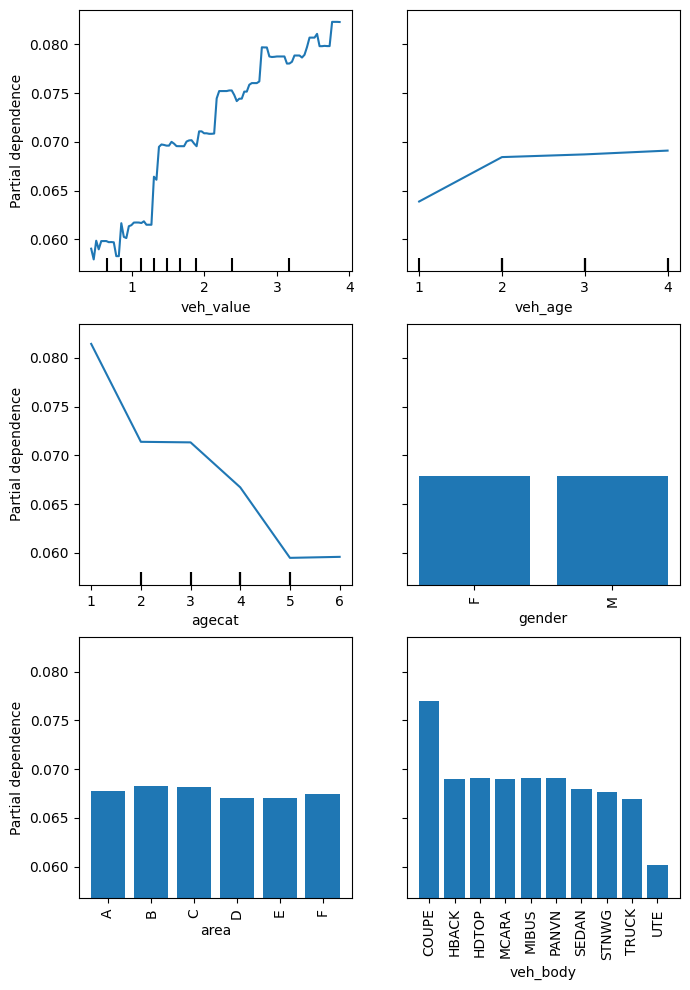

In [28]:
# Partial dependence plots
fig, axes = plt.subplots(figsize=(7, 10))

PartialDependenceDisplay.from_estimator(
    model,
    features=feature_names,
    categorical_features=cat_vars,
    X=df_train.sample(n=1000, random_state=1),
    n_cols=2,
    ax=axes,
)
fig.tight_layout()
